# Projekt Machine Learning - Regresja liniowa
## Opracowali: Jan Głębocki, Joanna Zawadzka, Patryk Zieliński

In [17]:
#import bibliotek
import pandas as pd
import datetime as dt
from datetime import timedelta
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as smf

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold

from sklearn.metrics import r2_score

In [3]:
#import danych
df=pd.read_csv('weatherHistory.csv')

Pierwszym krokiem analizy jest sprawdzenie, czy w zaimportowanym datasecie nie występują braki:

In [4]:
#sprawdzenie braków danych
df.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

W międzyczasie zostały sprawdzone typy danych oraz podziały zmiennych na kategoryczne / numeryczne:
* Formatted Date - numeryczna (data)
* Summary - kategoryczna
* Precip Type - kategoryczna
* Temperature (C) - numeryczna
* Apparent Temperature (C) - numeryczna
* Humidity - numeryczna
* Wind Speed (km/h) - numeryczna
* Wind Bearing (degrees) - numeryczna
* Visibility (km) - numeryczna
* Loud Cover - numeryczna
* Pressure (millibars) - numeryczna
* Daily Summary - kategoryczna

In [5]:
#sprawdzenie typów danych
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


Braki w kolumnie Precip Type zostały uzupełnione z wykorzystaniem dominanty dla tej kolumny

In [6]:
#znalezienie dominanty
df['Precip Type'].value_counts().index[0]

'rain'

In [7]:
#uzupełnienie braków danych dominantą
df['Precip Type']=df['Precip Type'].fillna(df['Precip Type'].value_counts().index[0])

In [8]:
#konwersja typów danych
df['Formatted Date']=pd.to_datetime(df['Formatted Date'])

W kolumnie Pressure zostały znalezione braki danych w ilości ok. 1300 rekordów. Zera zastąpiono wartością średnią obliczoną dla pozostałych rekordów:

In [9]:
#obliczenie średniego ciśnienia dla wierszy >0
df['Pressure (millibars)'][df['Pressure (millibars)']>0].mean()

1016.8141401775862

In [10]:
#zastąpienie wierszy = 0 w ciśnieniu wartością średnią
df['Pressure (millibars)']=df['Pressure (millibars)'].replace(0,df['Pressure (millibars)'][df['Pressure (millibars)']>0].mean())

W kolejnym kroku analizy pod lupę poszły statystyki opisowe dla zmiennych numerycznych:

In [11]:
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1016.814140
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,7.726246
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,973.780000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1012.200000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.670000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


A następnie wykonano kilka wizualizacji w celu lepszego poznania datasetu:

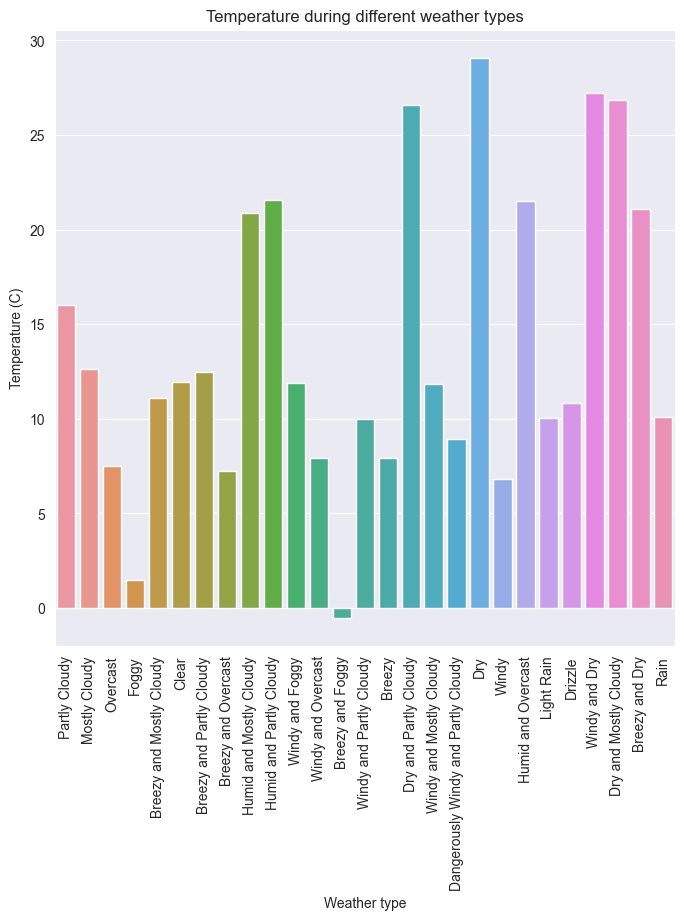

In [39]:
plt.figure(figsize=(8,8))
sns.barplot(data=df,x='Summary',y='Temperature (C)',errorbar=None).set(title='Temperature during different weather types')
plt.xticks(rotation=90)
plt.xlabel('Weather type')
plt.show()

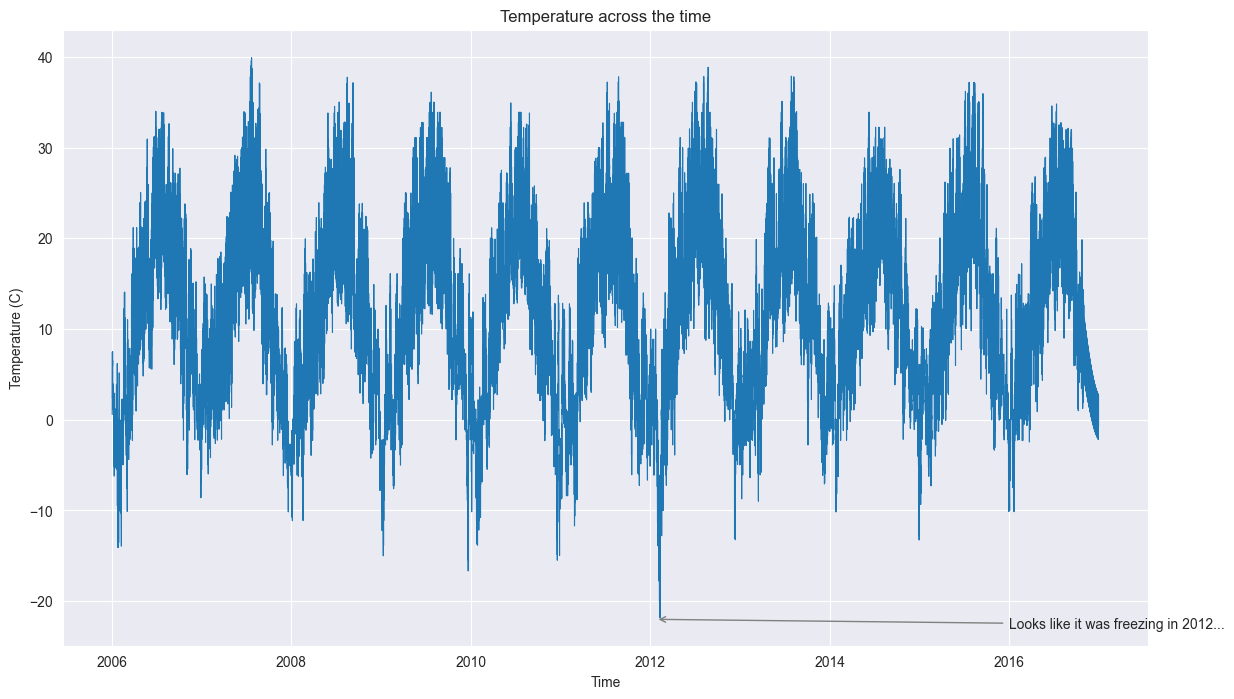

In [40]:
plt.figure(figsize=(14,8))
sns.lineplot(data=df,x='Formatted Date',y='Temperature (C)',linewidth=0.8).set(title='Temperature across the time')
plt.annotate('Looks like it was freezing in 2012...',xy=[pd.Timestamp('20120124'),-22],
                        xytext=(pd.Timestamp('2016'),-23),
                        arrowprops={'arrowstyle':"->",'color':'gray'})
plt.xlabel("Time")
plt.show()

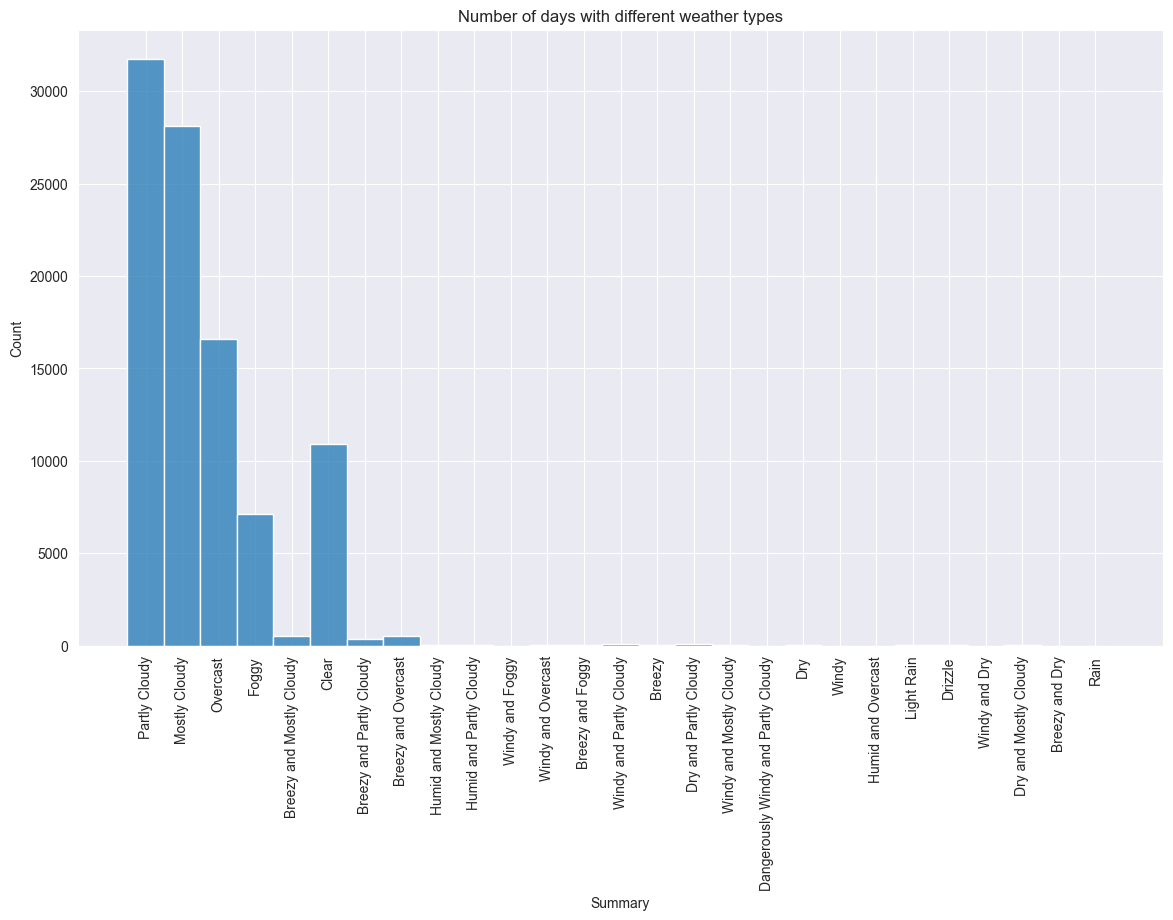

In [41]:
plt.figure(figsize=(14,8))
sns.histplot(data=df,x='Summary').set(title='Number of days with different weather types')
plt.xticks(rotation=90)
plt.show()

<Figure size 1200x1200 with 0 Axes>

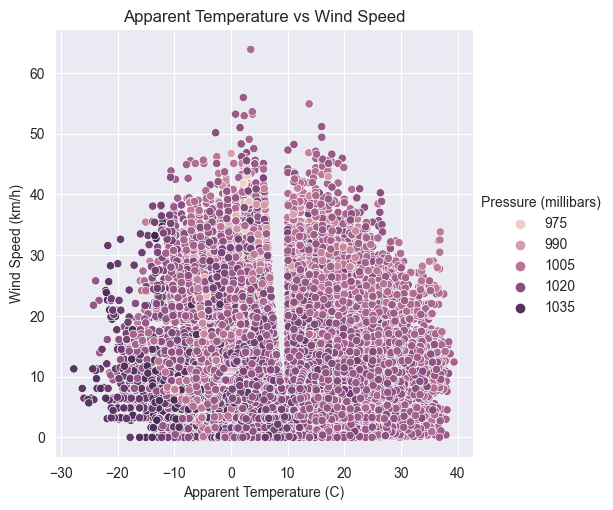

In [42]:
plt.figure(figsize=(12,12))
sns.relplot(data=df,y='Wind Speed (km/h)', x='Apparent Temperature (C)',
            hue='Pressure (millibars)').set(title='Apparent Temperature vs Wind Speed')
sns.color_palette("Set3")
plt.show()

W kolejnym kroku - selekcji zmiennych do modelu - usunięto zmienne kategoryczne oraz zmienną Apparent Temperature ze względu na spodziewaną wysoką korelację ze zmienną Temperature

In [12]:
#selekcja kolumn do modelu
df=df.drop(['Formatted Date','Apparent Temperature (C)','Summary','Precip Type','Daily Summary','Loud Cover'],axis=1)

In [13]:
df
df.columns=['Temperature','Humidity','WindSpeed','WindBearing','Visibility','Pressure']

Dla zredukowanego datasetu stworzono macierz korelacji:

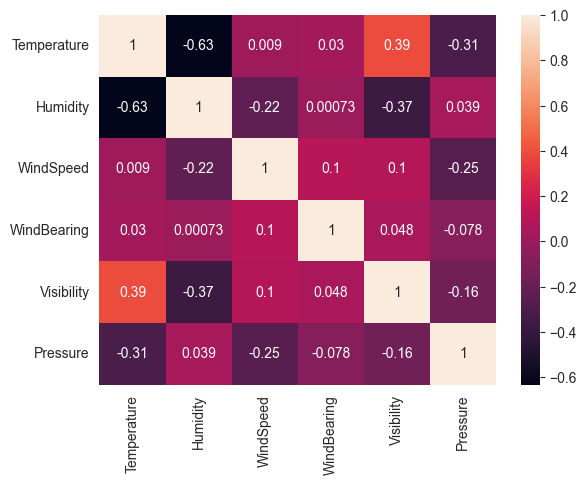

In [14]:
sns.heatmap(df.corr(),annot=True)
plt.show()

A następnie podzielono zmienne pod kątem stworzenia modeli regresji liniowej:

In [15]:
#podział zmiennych
y=df['Temperature']
df_linreg=df.drop('Temperature',axis=1)

Jako pierwszy został stworzony model regresji wykorzystujący równanie normalne (obiekt LinearRegression):

In [18]:
#model regresji - metoda równania normalnego
fit_reg=LinearRegression()
fit_reg.fit(df_linreg,y)

LinearRegression()

In [19]:
#stała do modelu
fit_reg.intercept_

432.77185562809655

In [20]:
#współczynniki dla zmiennych objaśniających do modelu
fit_reg.coef_

array([-3.03849919e+01, -3.12690184e-01,  2.03125635e-03,  3.02302576e-01,
       -3.92045885e-01])

Dla porówniania parametrów modelu wykorzystano też metodę OLS z pakietu statsmodels:

In [21]:
#II sposób
lin_reg = smf.ols(data = df, 
                  formula = 'Temperature ~ Humidity + WindSpeed + WindBearing + Visibility + Pressure').fit()

lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                 2.280e+04
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:56:36   Log-Likelihood:            -3.1690e+05
No. Observations:               96453   AIC:                         6.338e+05
Df Residuals:                   96447   BIC:                         6.339e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     432.7719      2.901    149.169      0.000     427.086     438.458
Humidity      -30.3850      0.117   -258.644      0.000     -30.615     -30.155
WindSpeed      -0.3127      0.003    -97.545      0.000      -0.319      -0.306
WindBearing     0.0020      0.000     10.392      0.000       0.002       0.002
Visibility      0.3023      0.005     55.754      0.000       0.292       0.313
Pressure       -0.3920      0.003   -138.767      0.000      -0.398      -0.387
==============================================================================
Omnibus:                     3322.536   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3739.896
Skew:                          -0.449   Prob(JB):                         0.00
Kurtosis:                       3.353   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Wstępna analiza modelu:
* 54% zmienności zmiennej objaśnianej jest wyjaśniane przez model
* zestaw zmiennych objaśniających jest istotny jako całość
* każda zmienna z osobna jest istotna w modelu
* reszty nie pochodzą z rozkładu normalnego (omnibus + test JB)
* wartość statystyki testowej Durbina-Watsona wskazuje na dodatnią autokorelację reszt modelu

W kolejnym kroku stworzono regresję z wykorzystaniem metody gradientu prostego.
Przed dopasowaniem modelu dane zostały poddane standaryzacji do rozkładu N(0,1)

In [22]:
#model regresji - metoda gradientu prostego (SGD regressor)
#zmienna zależna po standaryzacji
y=df['Temperature'].values.reshape(-1,1)

scale=StandardScaler()
#ramka danych po standaryzacji danych
scaled_df=scale.fit_transform(df.drop('Temperature',axis=1))

In [23]:
sgd_reg=SGDRegressor()
sgd_reg.fit(scaled_df,y)

SGDRegressor()

In [24]:
sgd_reg.intercept_

array([11.97398051])

In [25]:
sgd_reg.coef_

array([-5.89903058, -2.15135104,  0.03280891,  1.26450189, -3.18711907])

In [26]:
#dataframe do gradientu prostego
scaled_df = pd.concat([pd.DataFrame({"intercept": np.repeat(1., df.shape[0])}),
          pd.DataFrame(scaled_df)], axis = 1)

In [27]:
scaled_df.columns=['intercept','Humidity','WindSpeed','WindBearing','Visibility','Pressure']

Po stworzeniu modelu dobrano odpowiedni współczynnik gradientu.
Dla wartości 0,075 model zachowuje się najbardziej poprawnie ze wszystkich testowanych - powyżej tej wartości zaczyna się jego przetrenowanie.

In [29]:
params_history = pd.DataFrame()

params = np.random.randn(6,1)
m = scaled_df.shape[0]
eta = 0.075
n_iterations = 50

n_iter = 0
for i in range(n_iterations):
    gradients = 2/m * scaled_df.T.dot(scaled_df.dot(params) - y)
    params = params - eta * gradients
    params_history = pd.concat([params_history,
                               pd.DataFrame({"step": [n_iter],
                                            "a0": [params.loc["intercept",0]],
                                            "a1": [params.loc["Humidity",0]],
                                            "a2": [params.loc["WindSpeed",0]],
                                            "a3": [params.loc["WindBearing",0]],
                                            "a4": [params.loc["Visibility",0]],
                                            "a5": [params.loc["Pressure",0]],
                                            "gradient_a0": [gradients.loc["intercept", 0]],
                                            "gradient_a1": [gradients.loc["Humidity", 0]],
                                            "gradient_a2": [gradients.loc["WindSpeed", 0]],
                                            "gradient_a3": [gradients.loc["WindBearing", 0]],
                                            "gradient_a4": [gradients.loc["Visibility", 0]],
                                            "gradient_a5": [gradients.loc["Pressure", 0]],
                                            })])
    
    #if (np.abs(gradients.loc["intercept", 0]) < 100 and 
    #    np.abs(gradients.loc["Humidity", 0]) < 100 and
    #    np.abs(gradients.loc["WindSpeed", 0]) < 100 and
    #    np.abs(gradients.loc["WindBearing", 0]) < 100 and
    #    np.abs(gradients.loc["Visibility", 0]) < 100 and
    #    np.abs(gradients.loc["Pressure", 0]) < 100) or n_iter > 100000:
    #    break
    n_iter += 1

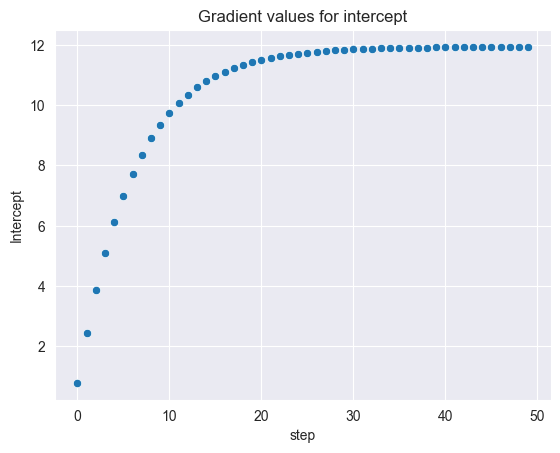

In [30]:
sns.scatterplot(data = params_history, x = "step", y = "a0").set(title="Gradient values for intercept")
plt.ylabel("Intercept")
plt.show()

Parametry modelu regresji po analizie z wykorzystaniem algorytmu gradientu prostego przedstawiono w poniższym DataFrame:

In [31]:
#parametry do modelu obliczone z wykorzystaniem algorytmu gradientu prostego
params

,0
intercept,11.928801
Humidity,-5.893445
WindSpeed,-2.129322
WindBearing,0.211923
Visibility,1.307309
Pressure,-3.000634


Trzecią wykorzystaną metodą analizy jest drzewo decyzyjne:
Poniższy wykres przedstawia już docelowe dopasowanie po obliczeniu i porównaniu wartości MSE dla zbiorów testowego i treningowego dla głębokości drzewa z zakresu 1- 10.

In [32]:
#drzewo decyzyjne

tree_reg = DecisionTreeRegressor(max_depth = 5)
tree_reg.fit(df_linreg,y)

DecisionTreeRegressor(max_depth=5)

[Text(0.5, 0.9166666666666666, 'x[0] <= 0.635\nsquared_error = 91.231\nsamples = 96453\nvalue = 11.933'),
 Text(0.25, 0.75, 'x[0] <= 0.475\nsquared_error = 66.469\nsamples = 27370\nvalue = 20.53'),
 Text(0.125, 0.5833333333333334, 'x[4] <= 1023.405\nsquared_error = 52.221\nsamples = 13164\nvalue = 23.885'),
 Text(0.0625, 0.4166666666666667, 'x[0] <= 0.365\nsquared_error = 42.261\nsamples = 11775\nvalue = 24.889'),
 Text(0.03125, 0.25, 'x[1] <= 22.411\nsquared_error = 40.013\nsamples = 4945\nvalue = 26.878'),
 Text(0.015625, 0.08333333333333333, 'squared_error = 34.179\nsamples = 4425\nvalue = 27.503'),
 Text(0.046875, 0.08333333333333333, 'squared_error = 58.086\nsamples = 520\nvalue = 21.563'),
 Text(0.09375, 0.25, 'x[1] <= 22.226\nsquared_error = 38.948\nsamples = 6830\nvalue = 23.449'),
 Text(0.078125, 0.08333333333333333, 'squared_error = 35.706\nsamples = 6149\nvalue = 23.917'),
 Text(0.109375, 0.08333333333333333, 'squared_error = 48.32\nsamples = 681\nvalue = 19.216'),
 Text(0.1

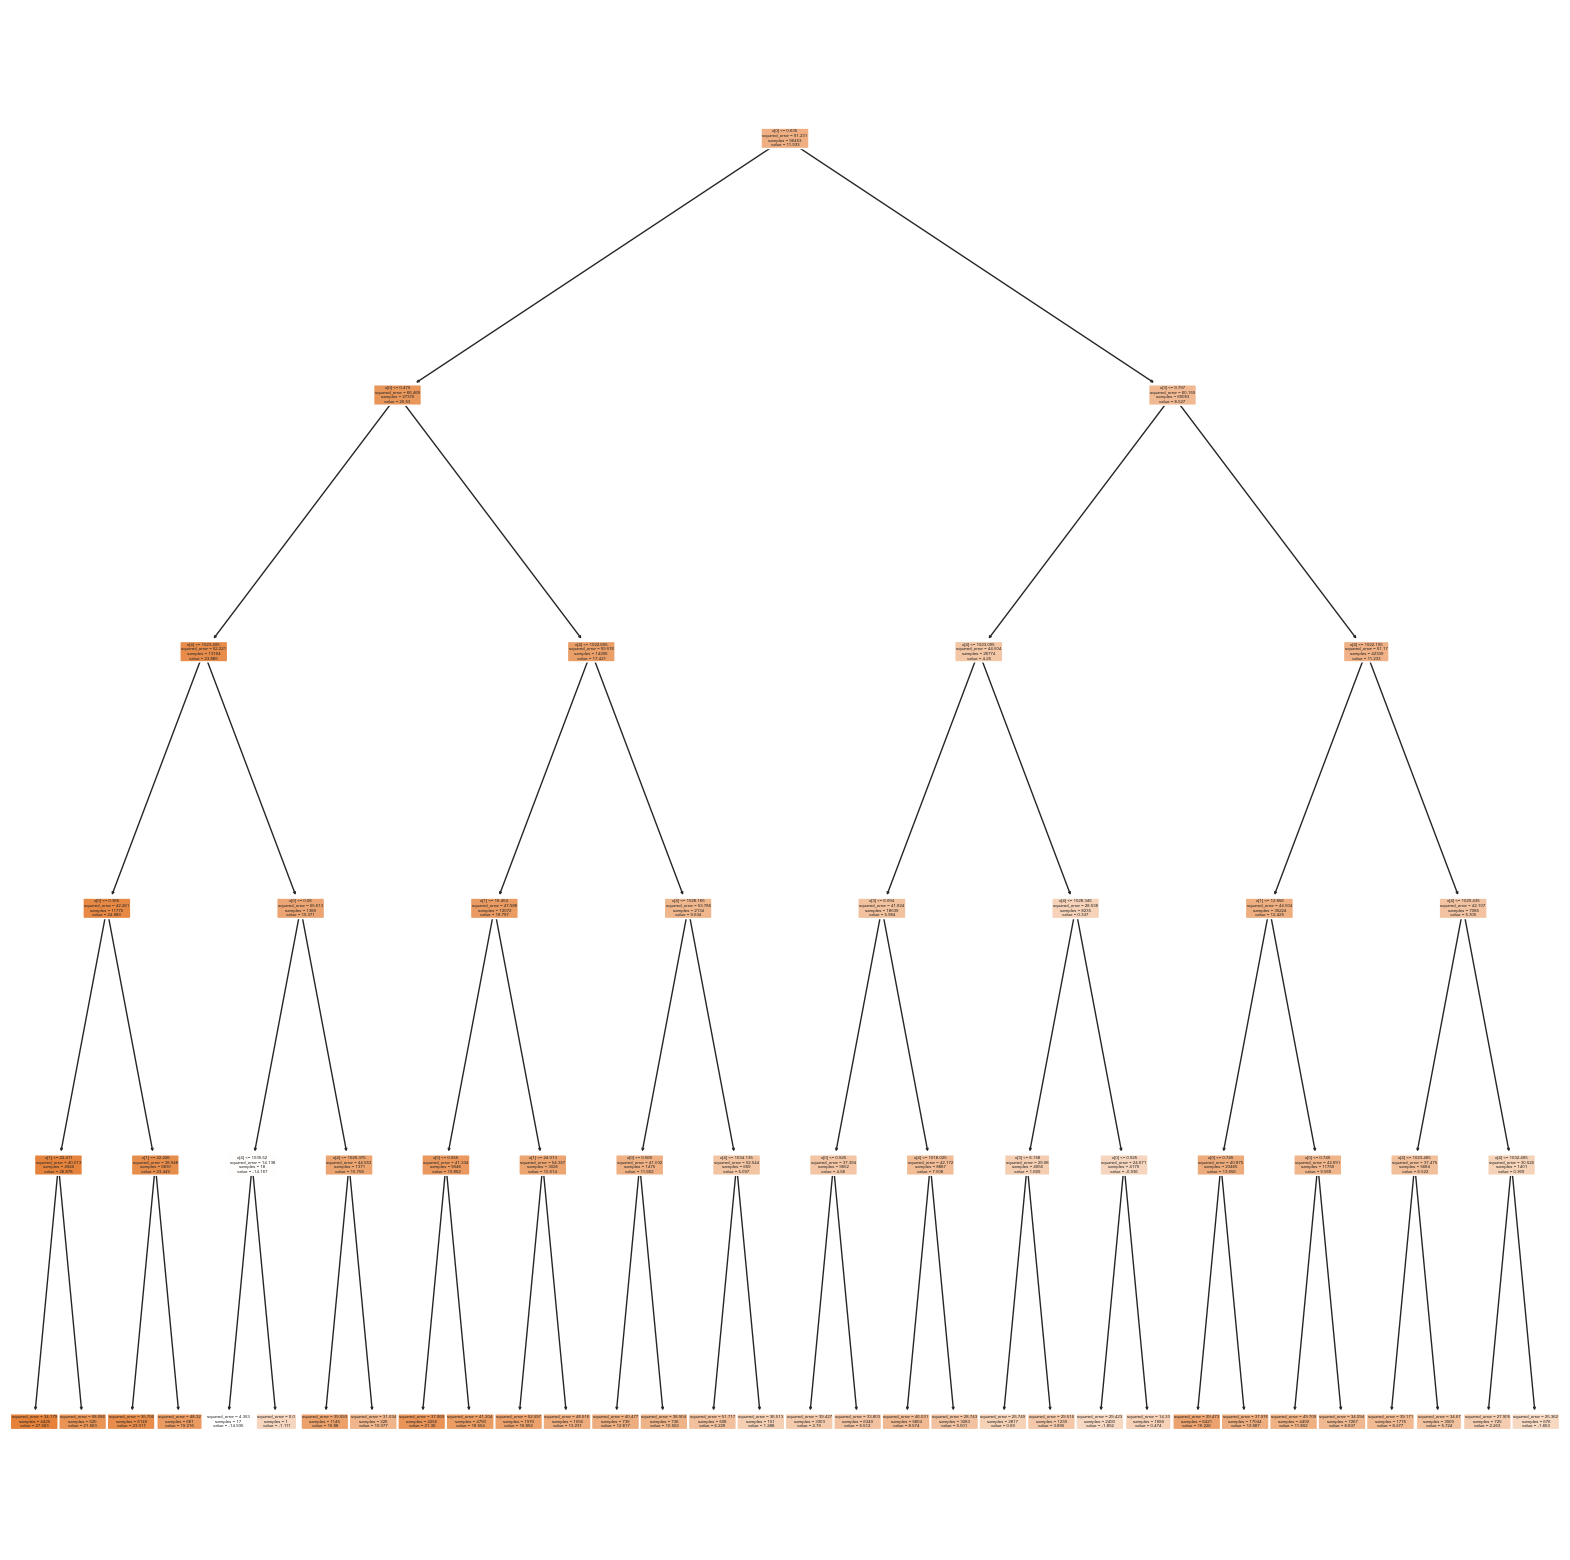

In [33]:
plt.figure(figsize = (20, 20))
sklearn.tree.plot_tree(tree_reg, filled=True, rounded=True)

W celu znalezienia optymalnej głębokości drzewa zbiór danych uległ podziałowi na zbiór treningowy i testowy w proporcji 4:1

In [34]:
#podział zbioru na treningowy i testowy
train_df, test_df = train_test_split(df_linreg,test_size=0.2)

In [35]:
summary_table=pd.DataFrame()

for i in np.arange(1,11):
    for j in range(100):
        #stworzenie zbiorów treingowych i testowych
        X_train, X_test, y_train, y_test = train_test_split(df_linreg,y,test_size=0.2)
        #stworzenie drzewa decyzyjnego
        tree = DecisionTreeRegressor(max_depth=i)
        #trening modelu
        tree.fit(X_train, y_train)
        
        #wartości predykcji
        test_pred=tree.predict(X_test)
        train_pred=tree.predict(X_train)
        
        #obliczenie błędów predykcji
        train_mse = mean_squared_error(y_train, train_pred) 
        test_mse = mean_squared_error(y_test , test_pred)
        
        #aktualizacja df z wynikami
        summary_table=pd.concat([summary_table,
                                 pd.DataFrame({"max_depth": [i],
                                              "train_mse": [train_mse],
                                              "test_mse": [test_mse]})])

In [36]:
agg_summary_table=summary_table.groupby('max_depth').agg(
    train_mse=('train_mse','mean'),
    test_mse=('test_mse','mean'))

Wyniki porównania MSE dla zbioru treningowego i testowego przedstawiono na wykresie:

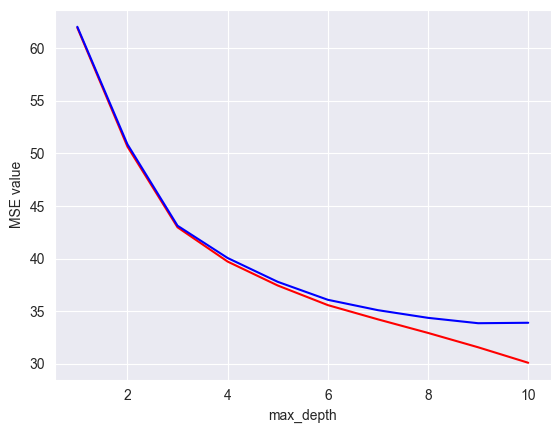

In [47]:
sns.lineplot(data = agg_summary_table, x = "max_depth", y = "train_mse",color='red')
sns.lineplot(data = agg_summary_table, x = "max_depth", y = "test_mse",color='blue')
plt.ylabel("MSE value")
plt.show()

Oraz w poniższym dataframe:

In [76]:
agg_summary_table

,train_mse,test_mse
max_depth,,
1,61.943508,62.014084
2,50.676014,50.783637
3,42.970976,43.180208
4,39.740734,40.031118
5,37.438340,37.847740
6,35.563756,36.198816
7,34.232531,35.124631
8,32.923705,34.395532
9,31.575083,33.905266


Jednym z ostatnich kroków analizy było wykonanie sprawdzianu krzyżowego. W tym celu wykorzystano k-krotny sprawdzian krzyżowy (metoda Leave One Out dla tego zbioru za bardzo przeciąża sprzęt)

In [49]:
#k-krotny sprawdzian krzyżowy

cv = KFold(n_splits = 5, shuffle = True, random_state=42)

for train, test in cv.split(df):
    X_train, y_train = df_linreg.iloc[train,:],pd.DataFrame(y).iloc[train]
    X_test, y_test = df_linreg.iloc[test,:],pd.DataFrame(y).iloc[test]
    print(train_df.shape, test_df.shape)

(77162, 5) (19291, 5)
(77162, 5) (19291, 5)
(77162, 5) (19291, 5)
(77162, 5) (19291, 5)
(77162, 5) (19291, 5)


Na koniec stworzono prognozę dla modelu oraz porównanie wartości współczynnika determinacji:

In [50]:
#współczynnik determinacji

model = LinearRegression()
model.fit(df_linreg,y)

LinearRegression()

In [51]:
y_predict=model.predict(df_linreg)

In [52]:
r2_score(y, y_predict)

0.5416748037895277